# <center> Crash Course on Variational Monte Carlo </center>
<center> Lecture 2: Markov Chain Monte Carlo and Netket</center>

<h3><center>Filippo Vicentini</center></h3>

<center>filippo.vicentini@epfl.ch</center>


<center>https://github.com/PhilipVinc/vmc-crash-course-2010</center>



EPFL, 22 October 2020

# Setup / Prerequisites

- Python >= 3.6
- Jax
- NetKet@v3.0 
- MPI compiler (mandatory only if you are on linux)
    `sudo apt install mpich`

```python
➜ python3 --version
Python 3.8.5

➜ which mpicc
/usr/local/bin/mpicc

➜ mkdir netket-lectures && cd netket-lectures

➜ python3 -m venv nk-env

➜ source nk-env/bin/activate

➜ which python
/Users/filippovicentini/netket-lectures/nk-env/bin/python
```

```python

➜ pip install jax jaxlib mpi4jax matplotlib
...

➜ pip install git+https://github.com/netket/netket@v3.0
...

# To activate jupyter
➜ pip install jupyterlab ipykernel

➜ python -m ipykernel install --name "netket-lectures" 

➜ jupyter lab
```

In [1]:
# Some imports®
import jax
import numpy as np
from jax import numpy as jnp
from matplotlib import pyplot as plt

# <center>Jastrow Wavefunction</center>

The jastrow ansatz for the wavefunction is:
$$
\psi_{W}(\sigma_1, \dots, \sigma_N) = \exp[\sum_{i,j} \sigma_i W_{i,j} \sigma_j] = \exp[\sigma^T W \sigma]
$$

We actually want to encode the 
$$
\log\psi_{W}(\sigma_1, \dots, \sigma_N) = \sigma^T W \sigma
$$


# Storing numerical data

In python we can store data within lists (Cell arrays in Matlab):

In [2]:
my_list = [1,2,3,4, 1.5, 2.3, 3.5]
print(my_list)

[1, 2, 3, 4, 1.5, 2.3, 3.5]


However this does not store contiguously the numerical data, which will lead to very bad performance.

<img src="img/pylist.png" alt="img/pylist" width="300"/>

Alternatively, we can use Numpy N-dimensional arrays, which store data contiguously
<img src="img/pyarray.png" alt="img/pyarray" width="150"/>

In [3]:
import numpy as np

a = np.array([1,2,3,4, 1.5, 2.3, 3.5])
print("The array is: ", a)
print("It contains elements of homogeneous type: " , a.dtype)
print("It has shape: ", a.shape)

The array is:  [1.  2.  3.  4.  1.5 2.3 3.5]
It contains elements of homogeneous type:  float64
It has shape:  (7,)


<center><strong>Always use Numpy for numerical data</strong></center>

# Row-Major and Column-Major

Data of matrices is stored contiguously, so we should also access it contiguously

In [196]:
W = np.random.rand(4096, 4096)

# Why is it important to have contiguous data:
%timeit W[:,0].mean()
%timeit W[0,:].mean()

76.9 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.41 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Jastrow Wavefunction

The jastrow ansatz for the wavefunction is:
$$
\log\psi_{W}(\sigma_1, \dots, \sigma_N) = \sigma^T W \sigma
$$

The matrix $W\in\mathbb{C}^N\times\mathbb{C}^N$  while $\sigma\in\mathcal{H}\sim\{\pm1\}^N$

In [5]:
# Generate the weight matrix and a state
def jastrow_init(N):
    # Sum the real and imaginary parts, both normally distributed around 0
    W = np.random.randn(N, N) + 1j * np.random.randn(N, N)
    
    # Take N times one element in the set {0,1}
    σ = np.random.choice([-1, 1], N)
    
    return W, σ

In [6]:
W, σ = jastrow_init(2**10)
print("The shape of W is:", W.shape, "and type:", W.dtype)
print("The shape of σ is:", σ.shape, "and type:", σ.dtype)

The shape of W is: (1024, 1024) and type: complex128
The shape of σ is: (1024,) and type: int64


In [7]:
%timeit np.dot(σ, np.dot(W, σ))

416 µs ± 43.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
# Convert to single precision
W_sd = W.astype(np.complex64)
σ_sd = σ.astype(np.float32)

%timeit np.dot(σ_sd, np.dot(W_sd, σ_sd))

112 µs ± 7.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In general it is computationally more efficient to use single precision than double, unless you need that extra precision.

In [9]:
# Generate the weight matrix and a state
def jastrow_init(N):
    # Sum the real and imaginary parts, both normally distributed around 0
    W = np.random.randn(N, N) + 1j * np.random.randn(N, N)
    
    # Take N times one element in the set {0,1}
    σ = np.random.choice([-1, 1], N)
    
    # Convert those matrices to single precision
    return W.astype(np.complex64), σ.astype(np.float32)

$$
\psi_{W}(\sigma_1, \dots, \sigma_N) = \exp[\sum_{i,j} \sigma_i W_{i,j} \sigma_j] = \exp[\sigma^T W \sigma]
$$

In [10]:
# Let's define the algorithm in python
def jastrow_py(W,σ):
    res = 0.0
    N = len(σ)
    for i in range(N):
        for j in range(N):
            res += σ[i]*W[i,j]*σ[j]
    return res

In [11]:
# Let's define the algorithm in python
def jastrow_np(W,σ):
    return np.dot(σ, np.dot(W, σ))

In [12]:
W, σ = jastrow_init(2**10)
print(jastrow_py(W, σ))
print(jastrow_np(W, σ))

(-536.3853633862235+519.6094370875746j)
(-536.3849+519.60913j)


 Which one is faster?

In [13]:
# Now let's see how it scales
Ns = np.array([16, 32, 64, 128, 256, 512, 1024, 2048, 4096])

In [14]:
times_py = []

for N in Ns[:6]:
    A, v = jastrow_init(N)
    
    tpy = %timeit -q -o -r2 jastrow_py(A, v)
    times_py.append(tpy.average)

In [15]:
times_np = []

for N in Ns[:9]:
    A, v = jastrow_init(N)
    
    tnp = %timeit -q -o -r2 jastrow_np(A, v)    
    times_np.append(tnp.average)

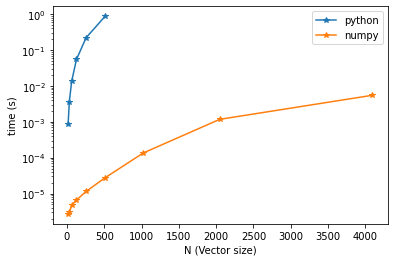

In [16]:
times_fig = plt.figure("Jastrow timings")
ax = plt.subplot(111)
ax.set_xlabel("N (Vector size)")
ax.set_ylabel("time (s)");

ax.plot(Ns[:len(times_py)], times_py, label="python", marker="*");
ax.plot(Ns[:len(times_np)], times_np, label="numpy", marker="*");
ax.legend()
ax.set_yscale("log");

# Using Jax
Jax is a library developed by google that re-implements NumPy, exposing some usefull extra functionalities...

In [17]:
import jax

In [18]:
W  = np.random.rand(4,4)
print(type(W))
Wj = jax.numpy.array(W)
print(type(Wj))
Wj + 10

<class 'numpy.ndarray'>
<class 'jax.interpreters.xla.DeviceArray'>


/Users/filippovicentini/Documents/pythonenvs/teach-1-nk/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([[10.2254715, 10.847579 , 10.881239 , 10.768181 ],
             [10.77719  , 10.404031 , 10.981039 , 10.150138 ],
             [10.593621 , 10.836733 , 10.361648 , 10.136488 ],
             [10.169981 , 10.58313  , 10.275138 , 10.134008 ]],            dtype=float32)

In [19]:
# jax.numpy behaves the same as numpy, but always returns
from jax import numpy as jnp

In [20]:
def jastrow_init_jax(N):
    W, σ = jastrow_init(N)
    return jnp.array(W), jnp.array(σ)

In [21]:
def jastrow_jax(W,σ):
    return jnp.dot(σ, jnp.dot(W, σ))

In [22]:
times_jax = []

for N in Ns[:9]:
    A, v = jastrow_init_jax(N)
    
    tpy = %timeit -q -o -r2 jastrow_jax(A, v)
    times_jax.append(tpy.average)

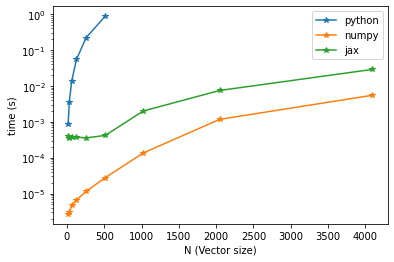

In [23]:
ax.plot(Ns[:len(times_jax)], times_jax, label="jax", marker="*");
ax.legend()
times_fig

In [24]:
# Just-in-time compilation of the function
def jastrow_jax_test(W,σ):
    print("executing on W of type", type(W), "and shape", W.shape)
    print("             σ of type", type(σ), "and shape", σ.shape)

    return jnp.dot(σ, jnp.dot(W, σ))

In [25]:
A, v = jastrow_init_jax(2)

jastrow_jax_test(A,v)

executing on W of type <class 'jax.interpreters.xla.DeviceArray'> and shape (2, 2)
             σ of type <class 'jax.interpreters.xla.DeviceArray'> and shape (2,)


DeviceArray(1.9205296-2.0026445j, dtype=complex64)

In [26]:
jastrow_jax_jit = jax.jit(jastrow_jax_test)

%time jastrow_jax_jit(A,v);

executing on W of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (2, 2)
             σ of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (2,)
CPU times: user 18.8 ms, sys: 1.92 ms, total: 20.7 ms
Wall time: 17.6 ms


DeviceArray(1.9205296-2.0026445j, dtype=complex64)

In [27]:
%time jastrow_jax_jit(A,v);
%time jastrow_jax_jit(A,v);

CPU times: user 447 µs, sys: 173 µs, total: 620 µs
Wall time: 438 µs
CPU times: user 454 µs, sys: 335 µs, total: 789 µs
Wall time: 419 µs


DeviceArray(1.9205296-2.0026445j, dtype=complex64)

In [28]:
A, v = jastrow_init_jax(3)

%time jastrow_jax_jit(A,v);

executing on W of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (3, 3)
             σ of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (3,)
CPU times: user 26 ms, sys: 2.02 ms, total: 28 ms
Wall time: 24.6 ms


DeviceArray(1.4897292+2.3282783j, dtype=complex64)

In [29]:
times_jax = []

for N in Ns[:9]:
    A, v = jastrow_init_jax(N)
    
    # warmup the jit
    jastrow_jax_jit(A, v);
    
    tpy = %timeit -q -o -r2 jastrow_jax_jit(A, v)
    times_jax.append(tpy.average)

executing on W of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (16, 16)
             σ of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (16,)
executing on W of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (32, 32)
             σ of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (32,)
executing on W of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (64, 64)
             σ of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (64,)
executing on W of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (128, 128)
             σ of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (128,)
executing on W of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (256, 256)
             σ of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> and shape (256,)

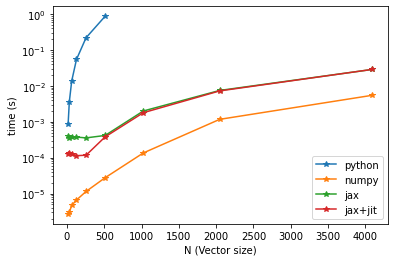

In [30]:
ax.plot(Ns[:len(times_jax)], times_jax, label="jax+jit", marker="*");
ax.legend()
times_fig

## Using NetKet 
The devil is in the python

In [31]:
# Importing netket (that ain't too hard)
import netket as nk

In [32]:
# How many spins we want in our model
N = 8 

# Define a 1D lattice (or graph) for our model
graph = nk.graph.Grid([N], pbc=True)

In [33]:
# Define the Hilbert space
ℋ = nk.hilbert.Spin(graph, s=0.5)

In [34]:
# The Graph...
graph

Grid(length=[8], pbc=True)

In [35]:
# number of nodes
graph.n_sites

8

In [36]:
# List of tuples of adjacent (connected) sites.
graph.adjacency_list()

[[1, 7], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [0, 6]]

# Defining the Network using Jax
The convention in Jax, also adopted by netket is that a network/variational function must be constructed through a function $f$ so that:
 - f takes arbitrary inputs, specifying it's structure
 - f returns 
      - An `init_function(rng, input_shape) -> (output_shape, parameters)`
      - An `apply_function(parameters, *inputs) -> result`

In [37]:
jastrow_jax_batch = jax.vmap(jastrow_jax, in_axes=(None, 0))

def Jastrow(W_init=jax.nn.initializers.glorot_normal()):
    def init_fun(rng, input_shape):
        # all dimensions except the last one
        N = input_shape[-1]
        input_batches = input_shape[:-1]
                        
        # Returns output shape and the weights
        return input_batches, W_init(rng, (N, N))

    def apply_fun(W, σb, **kwargs):    
        return jastrow_jax_batch(W, σb) 
    
    return init_fun, apply_fun

In [111]:
# Lastly, we wrap this machine in our own netket structure, 
# which takes as input the 
# - Hilbert space
# - The machine
# - the input (and output) types.
ψ = nk.machine.Jax(ℋ, Jastrow(), dtype=float)

# We initialize the weights with a factorised ansatz
tmp = jnp.diag(np.random.randn(N-1), k=1) * 0.11;
#tmp2 = jnp.diag(np.random.randn(N-2), k=2) * 2.1;
ψ.parameters = jnp.diag(np.random.randn(N)) + tmp + tmp.T.conj()

## Monte-Carlo Sampling
We want to identify the chain $\sigma \in \mathcal{S}$ so that $p(\sigma \in \mathcal{S})\approx \vert\psi(x)\vert^2$.

 - Easy! we compute $\frac{\vert\psi(\sigma)\vert^2}{\langle\psi\vert\psi\rangle}\ \  \forall \sigma \in \mathcal{H}$, we compute the CDF (cumulative distribution function) and then we sample from that

In [112]:
# We collect all the states in the Hilbert space
σ_all = ℋ.all_states()
print(σ_all.shape)

(256, 8)


In [113]:
# We compute the Probability distribution
logψ_v   = ψ.log_val(σ_all)
pdf_ex   = jnp.exp(2*logψ_v.real)
pdf_ex  /= sum(pdf_ex)
print("shape: ", pdf_ex.shape, "total = ", sum(pdf_ex))

shape:  (256,) total =  0.9999999790452421


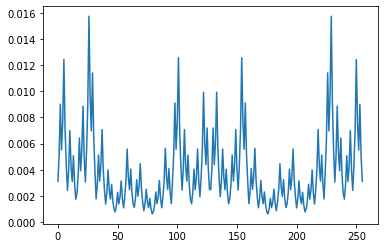

In [114]:
plt.plot(pdf_ex);

What is the computational complexity of this sampling, as a function of the number of spins $N$?

 - Hilbert space size:  $\dim[\mathcal{H}] = 2^N$
 - Number of samples:   $M$
 - Sampling Complexity ([binary search](https://en.wikipedia.org/wiki/Binary_search_algorithm), by looking at [numpy source](https://github.com/numpy/numpy/blob/feb0794bdb6709861b395818ddf0ea3548310e24/numpy/core/src/multiarray/item_selection.c#L1776)): $\mathcal{O}(\log(\dim[\mathcal{H}])) $ 
 
Direct Sampling Complexity :
 $$
\mathcal{O}(2^N + M\cdot N\log(2)) \approx \mathcal{O}(2^N)
 $$

## Monte-Carlo Sampling
We want to identify the chain $\sigma \in \mathcal{S}$ so that $p(\sigma \in \mathcal{S})\approx \vert\psi(x)\vert^2$.

 - Easy! we compute $\frac{\vert\psi(\sigma)\vert^2}{\langle\psi\vert\psi\rangle}\ \  \forall \sigma \in \mathcal{H}$, we compute the CDF (cumulative distribution function) and then we sample from that.
    - $\mathcal{O}(2^N)$ sampling complexity
    - This complexity arises from the denominator of the probability (if we can avoid computing it, we can reduce the complexity)
    - Autoregressive networks, for example, are ansatzes which are normalized by construction
    
 - Metropolis - Hastings : If we can compute a $f(\sigma) \propto p(\sigma)$, then we do not need to compute the full PDF. Asymptotically exact.

## Markov-Chain with Metropolis-Hastings
 - Consider the function $f(\sigma) = \vert\psi(\sigma)\vert^2 \propto p(\sigma)$.
 - Consider a function $T(\sigma' \vert \sigma)$ that given a state $\sigma$ it returns a transformed state $\sigma'$.    
     
 1. Generate an initial random state $\sigma^{0}$ 
 2. For every iteration i, $\sigma^{(i)}$: 
     1. Generate a candidate $\sigma'$ by sampling $T(\sigma'| \sigma^{(i)})$
     2. Calculate the acceptance probability:
    $$
    \alpha = \frac{p(\sigma')}{p(\sigma^{(i)})}\frac{T(\sigma'|\sigma^{(i)})}{T(\sigma^{(i)}|\sigma')} = \frac{\vert\psi(\sigma')\vert^2}{\vert\psi(\sigma^{(i)})\vert^2}\frac{T(\sigma'|\sigma^{(i)})}{T(\sigma^{(i)}|\sigma')} 
    $$
    3. Accept or reject the proposed state $\sigma'$ with probability $\alpha$:
       - Generate a uniform random number $r$ in the interval $[0,1]$
       - If $r<=\alpha$ then accept the proposed step and set $\sigma^{(i+1)} = \sigma'$
       - If $r>\alpha$ then reject the proposed step and set  $\sigma^{(i+1)} = \sigma^{(i)}$

Note that when the proposed state has a higher amplitude then the previous, $\alpha>1$ and the state will be accepted with probability $1$, instead if the state has a lower amplitude, the probability to accept it is exponentially suppressed, but never 0.

## Proof
If you are interested, the derivation of MCMC comes from trying to write a transition rule that is stationary at the target distribution

$$
P(\sigma'|\sigma)\pi(\sigma) = P(\sigma|\sigma')\pi(\sigma')
$$

where $P(\sigma'|\sigma)$ is the probability to go from a state $\sigma'$ from the state $\sigma$ and $\pi$ is the target distribution.

We define
$$
    P(\sigma'|\sigma)\equiv T(\sigma'|\sigma) A(\sigma', \sigma)
$$

where $T$ is the probability distribution for proposing a move, and A is the probability of accepting this move.
By substitution you get

$$
    \frac{A(\sigma', \sigma)}{A(\sigma, \sigma')} = \frac{\pi(\sigma')}{\pi(\sigma)}\frac{T(\sigma|\sigma') }{T(\sigma'|\sigma)} \equiv \alpha
$$

And Metropolis proposed to consider $A(\sigma', \sigma) = \min\left[1,\alpha\right]$ which satisfies the detailed balance equation above.

## Implementing a Metropolis-Hastings kernel in Netket

Kernel: a _CLASS_ constructed with `MyKernel(local_states, n_sites)` 
    
   Has two methods
   
   - The transition kernel `MyKernel.transition(rng, σ) -> σ'`
   - A random generator of states `MyKernel.random_state(rng, *args) -> σ'`

In [115]:
class LocalTransitionKernel:
    def __init__(self, local_states, size):
        self.local_states = jnp.sort(jnp.array(local_states))
        self.size = size
        self.n_states = self.local_states.size

    def transition(self, rng, σ):
        rng1, rng2 = jax.random.split(rng, 2)
        
        si = jax.random.randint(rng1, shape=(1,), minval=0, maxval=self.size)
        rs = jax.random.randint(rng2, shape=(1,), minval=0, maxval=self.n_states - 1)

        return jax.ops.index_update(
            σ, si, self.local_states[rs + (self.local_states[rs] >= σ[si])]
        )

    def random_state(self, key, state):
        keys = jax.random.split(key, 2)

        rs = jax.random.randint(
            keys[1], shape=(self.size,), minval=0, maxval=self.n_states
        )

        return keys[0], self.local_states[rs]


In [116]:
# So for example...
mh_kernel = LocalTransitionKernel(ℋ.local_states, ℋ.size)

In [117]:
# Jax PRNG Key
rng = jax.random.PRNGKey(123)

# generate a random state
rng, σ = mh_kernel.random_state(rng, None)
σ

DeviceArray([-1., -1.,  1.,  1.,  1., -1.,  1., -1.], dtype=float32)

In [118]:
print(σ)
# generate a random state
σp = mh_kernel.transition(rng, σ)
print(σp)

[-1. -1.  1.  1.  1. -1.  1. -1.]
[-1. -1.  1. -1.  1. -1.  1. -1.]


In [164]:
# Sampling
sampler = nk.sampler.MetropolisHastings(ψ, 
                                        LocalTransitionKernel(ℋ.local_states, ℋ.size), 
                                        n_chains=16, 
                                        sweep_size=1)

In [165]:
chain_length = 5000
states = np.zeros((chain_length, sampler.n_chains), dtype=int)

In [166]:
# let's reset the initial configuration to a random one
sampler.reset()

In [167]:
# Let's de-correlate from this initial condition by 'trashing' the first samples
for σb in sampler.samples(chain_length//20):
    pass

In [168]:
for (i, σb) in enumerate(sampler.samples(5000)):
    states[i, :] = ℋ.states_to_numbers(np.asarray(σb))

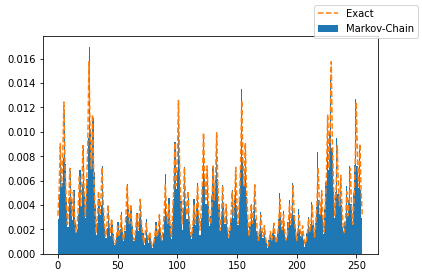

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111)
_, _, _ = ax.hist(states.reshape(-1), bins=256, density=True, label="Markov-Chain")
ax.plot(pdf_ex, label="Exact", linestyle='dashed');
fig.legend();

# The ising model
$$
\hat{H} = \frac{g}{2} \sum_i \sigma^{(x)}_i + \frac{V}{4}\sum_{\langle i,j\rangle} \sigma_i^{(z)}\sigma_j^{(z)}
$$

In [170]:
Ĥ = nk.operator.LocalOperator(ℋ)

for i in range(graph.n_nodes):
    Ĥ += 0.5 * nk.operator.spin.sigmax(ℋ, i)
    
for (i,j) in graph.adjacency_list():
    Ĥ += nk.operator.spin.sigmaz(ℋ, i) * nk.operator.spin.sigmaz(ℋ, j)

## Estimating the Energy $\langle \hat{H} \rangle$

We have seen on monday that observables can be rewritten as

$$
\langle \hat{A} \rangle = \sum_\sigma p(\sigma) A^\text{LOC}(\sigma) = \sum_\sigma p(\sigma) \left( \sum_{\sigma'} A(\sigma, \sigma')\frac{psi(\sigma')}{\psi(\sigma)} \right)
$$


In [171]:
# Now, let's try to estimate some observable: the energy
from netket.operator import define_local_cost_function
from functools import partial

In [172]:
@partial(define_local_cost_function, static_argnums=0, batch_axes=(None, None, 0, 0, 0))
def local_energy(logpsi, 𝒲, σp, A_σpσ, σ):
    return jax.numpy.sum(A_σpσ * jax.numpy.exp(logpsi(𝒲, σp) - logpsi(𝒲, σ.reshape(1,-1))))

In [173]:
# Convert the indices in the hilbert space to bit-strings
σ_samples = ℋ.numbers_to_states(states.reshape(-1))
print(σ_samples.shape)

(80000, 8)


In [174]:
# This command stores gets the non zero elements in the matrix, at the 'rows' of σ_samples
σp, A_σpσ = Ĥ.get_conn_padded(σ_samples)
# σp are the column...
print("σ_samples shape:", σ_samples.shape)
print("σp        shape:", σp.shape)
print("mel       shape:", A_σpσ.shape)

σ_samples shape: (80000, 8)
σp        shape: (80000, 9, 8)
mel       shape: (80000, 9)


In [175]:
from netket.operator import local_cost_function

eloc = local_cost_function(local_energy, ψ, σp, A_σpσ, σ_samples)
print("eloc      shape:", eloc.shape)

eloc      shape: (80000,)


In [176]:
eloc = eloc.reshape(-1, sampler.n_chains)
print("eloc      shape:", eloc.shape)

eloc      shape: (5000, 16)


$$
\langle \hat{H} \rangle = \sum_\sigma p(\sigma) E^\text{LOC}(\sigma) \sim \bar{E}^\text{LOC}
$$

In [177]:
# Eloc
print("E mean = ", eloc.mean())

E mean =  (3.8105695+0j)


* How do I know if this is a good estimate? 

The simplest thing: The mean local energy is distributed according to

$$
\bar{E}^\text{LOC} \sim \mathcal{N}\left(\langle E^\text{LOC}\rangle, \sigma_{\bar{E}^\text{LOC}}^2\right)
$$

Error of the mean or standard error:
$$
\sigma_{\bar{E}^\text{LOC}} = \sqrt{\frac{\sigma^2_{E^\text{LOC}}}{N}}
$$

$$\bar{E^\text{LOC}} = \langle E^\text{LOC}\rangle = \sum_{i=1}^N \frac{E_i^\text{LOC}}{N}$$
so by propagation of errors

$$
\sigma_{\bar{E}^\text{LOC}}^2 = \text{Var}\left(\sum_{i=1}^N \frac{E_i^\text{LOC}}{N}\right) = \frac{1}{N^2}\left(\sum_{i=1}^N E_i^\text{LOC}\right) = \frac{1}{N^2}\sum_{i=1}^N\text{Var}(E_i^\text{LOC}) = \frac{1}{N^2} N\sigma_E^2 = \frac{\sigma_E^2}{N}
$$

In [178]:
E_std_error = np.sqrt(eloc.var()/np.prod(eloc.shape))
print("E mean = ", eloc.mean(), "±", E_std_error)

E mean =  (3.8105695+0j) ± 0.0102420915


The simplest thing: The mean local energy is distributed according to

$$
\bar{E}^\text{LOC} \sim \mathcal{N}\left(\langle E^\text{LOC}\rangle, \sigma_{\bar{E}^\text{LOC}}^2\right)
$$

Error of the mean or standard error:
$$
\sigma_{\bar{E}^\text{LOC}} = \sqrt{\frac{\sigma^2_{E^\text{LOC}}}{N}}
$$

Note: The variance of $\sigma^2_{E^\text{LOC}}$ is the sample variance only if the samples are independent!

In [179]:
print("eloc shape: ", eloc.shape)
chain_Eloc = eloc.mean(axis=0)
chains_var = chain_Eloc.var()
chains_var

eloc shape:  (5000, 16)


DeviceArray(0.00795979, dtype=float32)

## Batching: De-correlate samples

Instead of computing the variance on $\{E_i^\text{Loc}\}$, compute it on $\{\sum_i=1^{N_b}\frac{1}{N_b}E_i^\text{Loc}\}$

In [187]:
batch_sizes = [1,2,4,8,16,32,64,128] 
pp = ((chain_length//batch_sizes[-1])*batch_sizes[-1])
eloc_c1 = eloc[0:pp,:].reshape(-1)
batch_vars = []

for bs in batch_sizes:
    eloc_c1r = eloc_c1.reshape(bs,-1)
    eloc_b = eloc_c1r.mean(axis=0)
    var_b = np.sqrt(eloc_b.var()/eloc_c1r.shape[1])
    batch_vars.append(var_b)


Text(0, 0.5, 'standard error')

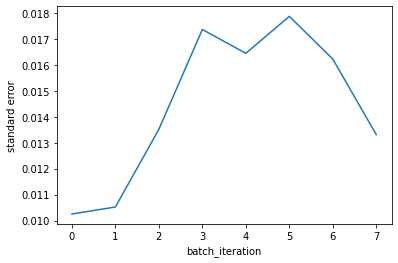

In [194]:
plt.plot(range(len(batch_sizes)), batch_vars)
plt.xlabel("batch_iteration")
plt.ylabel("standard error")

## How to compute gradients of functions..?

 - Do the calculations yourself, write code, (get bored to death)
     - Slightly change the function, you have to rewrite the gradient too...

In [65]:
- Finite differences

SyntaxError: invalid syntax (<ipython-input-65-d5f4abac073f>, line 1)

-

# How to estimate the (steepest) conjugate gradient?

$$
F = \langle O H \rangle = 
$$

In [ ]:
from netket.operator import local_costs_and_grads_function

eloc , grad_eloc = local_costs_and_grads_function(local_energy, ψ, σp, mel, σ_samples)
print("grad_eloc shape is: ", grad_eloc.shape)

$$
\Delta \hat{O} \equiv \hat{O} - \langle\hat{O}\rangle
$$

Therefore, every sample gets transformed:

$$
O^{i} = O^{i} - \frac{1}{N_\text{s}} \sum_{i=1}^{N_{\text{s}}} O^{i}
$$

In [ ]:
### Centering the gradient
grad_eloc_centered = grad_eloc - grad_eloc.mean(axis=0)

print("grad_eloc mean:\n", grad_eloc_centered.mean(axis=0)[0:2, 0:2])